# Impurity Measures on Mushroom Dataset

Σε αυτό το notebook θα δούμε πώς **διαφορετικές μετρικές καθαρότητας** (impurity measures)
επηρεάζουν:

- την **αξιολόγηση των χαρακτηριστικών** (ποια θεωρούνται πιο σημαντικά)
- και έμμεσα τις **επιλογές ενός δέντρου αποφάσεων**.

Θα χρησιμοποιήσουμε το *Mushroom Classification* dataset:

- Στόχος: `class` (edible (βρώσιμο) `e` ή poisonous (δηλητηριώδες) `p`)
- Χαρακτηριστικά: αποκλειστικά **κατηγορικά** (π.χ. `odor`, `cap-color`, `gill-size`)

Μετρικές που θα υπολογίσουμε για κάθε χαρακτηριστικό:

- **Entropy / Information Gain**
- **Split Information & Gain Ratio**
- **Gini Impurity / Gini Gain**

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Αν το notebook βρίσκεται στον φάκελο notebooks/, τότε το ROOT είναι ένας κατάλογος πάνω
ROOT = Path("..").resolve()
DATA_PATH = ROOT / "data" / "mushrooms.csv"

In [ ]:
# ----------------------------------------------
# ΥΠΟΛΟΓΙΣΜΟΣ ENTROPY
# ----------------------------------------------
def entropy(y: pd.Series) -> float:
    """Υπολογίζει την εντροπία (entropy) για μια στήλη κατηγορικών τιμών.

    Τύπος:
        H = - Σ (p_i * log2(p_i))

    όπου p_i είναι η σχετική συχνότητα κάθε κατηγορίας.
    Αν όλες οι τιμές είναι ίδιες -> H = 0 (τέλεια καθαρότητα)
    Αν οι τιμές είναι ισοκατανεμημένες -> H = log2(k) (μέγιστη αβεβαιότητα)
    """
    p = y.value_counts(normalize=True)
    return float(-(p * np.log2(p)).sum())


# ----------------------------------------------
# ΥΠΟΛΟΓΙΣΜΟΣ GINI IMPURITY
# ----------------------------------------------
def gini_impurity(y: pd.Series) -> float:
    """Υπολογίζει την αβεβαιότητα Gini για μια στήλη κατηγορικών τιμών.

    Τύπος:
        G = 1 - Σ (p_i)^2

    Όπου p_i η πιθανότητα κάθε κατηγορίας.
    Όσο μικρότερη η G, τόσο πιο "καθαρός" ο κόμβος.
    """
    p = y.value_counts(normalize=True)
    return float(1.0 - (p**2).sum())


# ----------------------------------------------
# ΥΠΟΛΟΓΙΣΜΟΣ ΠΛΗΡΟΦΟΡΙΑΣ ΚΑΙ ΔΕΙΚΤΩΝ ΓΙΑ ΕΝΑ ΧΑΡΑΚΤΗΡΙΣΤΙΚΟ
# ----------------------------------------------
def feature_scores(df: pd.DataFrame, feature: str, target: str):
    """
    Υπολογίζει 4 δείκτες καθαρότητας για ένα κατηγορικό χαρακτηριστικό:

      - Information Gain (IG)
      - Split Information
      - Gain Ratio
      - Gini Gain

    Οι δείκτες αυτοί δείχνουν πόσο "πληροφοριακό" είναι το χαρακτηριστικό
    για την πρόβλεψη της μεταβλητής-στόχου.
    """

    y = df[target]
    n = len(df)

    # Πριν το split
    H_before = entropy(y)
    G_before = gini_impurity(y)

    # Μετά το split (weighted)
    H_after = 0.0
    G_after = 0.0
    split_info = 0.0

    # Για κάθε διαφορετική τιμή του feature
    for v, subset in df.groupby(feature):
        weight = len(subset) / n
        y_sub = subset[target]

        H_after += weight * entropy(y_sub)
        G_after += weight * gini_impurity(y_sub)

        if weight > 0:
            split_info -= weight * np.log2(weight)

    info_gain = H_before - H_after
    gini_gain = G_before - G_after
    gain_ratio = info_gain / split_info if split_info > 0 else 0.0

    return info_gain, split_info, gain_ratio, gini_gain

## 1. Φόρτωση δεδομένων & βασική εξερεύνηση

Θα φορτώσουμε το `mushrooms.csv`, θα δούμε τις πρώτες γραμμές και την κατανομή της κλάσης
(edible vs poisonous).

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
# Πληροφορίες για τις στήλες
df.info()

In [4]:
# Κατανομή της κλάσης-στόχου (edible vs poisonous)
df['class'].value_counts(normalize=True)

class
e    0.517971
p    0.482029
Name: proportion, dtype: float64

## 2. Υπολογισμός Information Gain, Gain Ratio και Gini Gain

Για κάθε χαρακτηριστικό θα υπολογίσουμε:

- **Information Gain**: πόσο μειώνεται η εντροπία αν κάνουμε split σε αυτό το feature.
- **Split Information**: πόσο "διασκορπισμένες" είναι οι τιμές του feature.
- **Gain Ratio**: IG κανονικοποιημένο με βάση το split info (αντισταθμίζει features με πολλές κατηγορίες).
- **Gini Gain**: αντίστοιχο του IG αλλά με Gini impurity αντί για entropy.

Στόχος: να συγκρίνουμε τη **σειρά σημαντικότητας** των χαρακτηριστικών ανά μετρική.


In [5]:
target = "class"  # 'e' ή 'p'
features = [c for c in df.columns if c != target]

rows = []
for feat in features:
    ig, si, gr, gg = feature_scores(df, feat, target)
    rows.append(
        {
            "feature": feat,
            "num_values": df[feat].nunique(),
            "info_gain": ig,
            "split_info": si,
            "gain_ratio": gr,
            "gini_gain": gg,
        }
    )

scores = pd.DataFrame(rows)
scores.head()

,feature,num_values,info_gain,split_info,gain_ratio,gini_gain
0,cap-shape,6,0.048797,1.652889,0.029522,0.030114
1,cap-surface,4,0.028590,1.575486,0.018147,0.019365
2,cap-color,10,0.036049,2.510143,0.014361,0.023824
3,bruises,2,0.192379,0.979327,0.196440,0.125604
4,odor,9,0.906075,2.319414,0.390648,0.470817


In [6]:
print("=== Top 10 features by Information Gain ===")
display(scores.sort_values("info_gain", ascending=False).head(10))

print("\n=== Top 10 features by Gain Ratio ===")
display(scores.sort_values("gain_ratio", ascending=False).head(10))

print("\n=== Top 10 features by Gini Gain ===")
display(scores.sort_values("gini_gain", ascending=False).head(10))

=== Top 10 features by Information Gain ===


,feature,num_values,info_gain,split_info,gain_ratio,gini_gain
4,odor,9,0.906075,2.319414,0.390648,0.470817
19,spore-print-color,9,0.480705,2.203227,0.218182,0.282871
8,gill-color,12,0.416978,3.030433,0.137597,0.231465
18,ring-type,5,0.318022,1.535121,0.207164,0.181733
11,stalk-surface-above-ring,4,0.284726,1.221348,0.233124,0.172616
12,stalk-surface-below-ring,4,0.271894,1.399135,0.194330,0.165005
13,stalk-color-above-ring,9,0.253845,1.936809,0.131064,0.137556
14,stalk-color-below-ring,9,0.241416,1.978163,0.122040,0.132300
7,gill-size,2,0.230154,0.892256,0.257946,0.145625
20,population,6,0.201958,2.003398,0.100808,0.118614



=== Top 10 features by Gain Ratio ===


,feature,num_values,info_gain,split_info,gain_ratio,gini_gain
4,odor,9,0.906075,2.319414,0.390648,0.470817
7,gill-size,2,0.230154,0.892256,0.257946,0.145625
11,stalk-surface-above-ring,4,0.284726,1.221348,0.233124,0.172616
19,spore-print-color,9,0.480705,2.203227,0.218182,0.282871
18,ring-type,5,0.318022,1.535121,0.207164,0.181733
3,bruises,2,0.192379,0.979327,0.196440,0.125604
12,stalk-surface-below-ring,4,0.271894,1.399135,0.194330,0.165005
6,gill-spacing,2,0.100883,0.637878,0.158154,0.060608
8,gill-color,12,0.416978,3.030433,0.137597,0.231465
13,stalk-color-above-ring,9,0.253845,1.936809,0.131064,0.137556



=== Top 10 features by Gini Gain ===


,feature,num_values,info_gain,split_info,gain_ratio,gini_gain
4,odor,9,0.906075,2.319414,0.390648,0.470817
19,spore-print-color,9,0.480705,2.203227,0.218182,0.282871
8,gill-color,12,0.416978,3.030433,0.137597,0.231465
18,ring-type,5,0.318022,1.535121,0.207164,0.181733
11,stalk-surface-above-ring,4,0.284726,1.221348,0.233124,0.172616
12,stalk-surface-below-ring,4,0.271894,1.399135,0.194330,0.165005
7,gill-size,2,0.230154,0.892256,0.257946,0.145625
13,stalk-color-above-ring,9,0.253845,1.936809,0.131064,0.137556
14,stalk-color-below-ring,9,0.241416,1.978163,0.122040,0.132300
3,bruises,2,0.192379,0.979327,0.196440,0.125604


### Παρατήρηση

Συχνά θα δούμε ότι:

- Χαρακτηριστικά όπως η **οσμή (`odor`)** έχουν πολύ υψηλό **Information Gain** και **Gini Gain**,
  γιατί διαχωρίζουν σχεδόν τέλεια φαγώσιμα από δηλητηριώδη μανιτάρια.
- Το **Gain Ratio** μπορεί να αλλάξει ελαφρώς τη σειρά, επειδή τιμωρεί features με
  πάρα πολλές κατηγορίες (ψηλό split info).

Έτσι, διαφορετικές μετρικές μπορεί να προτείνουν **διαφορετική "προτεραιότητα" χαρακτηριστικών**,  
ειδικά όταν κάποια έχουν πολλές μοναδικές τιμές.


## 3. Δέντρα αποφάσεων με διαφορετικά κριτήρια (entropy vs gini)

Τώρα θα εκπαιδεύσουμε δύο δέντρα αποφάσεων:

- Ένα με **criterion = "entropy"**
- Ένα με **criterion = "gini"**

και θα συγκρίνουμε:

- την απόδοση (accuracy),
- τις **feature importances**.

Έτσι θα δούμε στην πράξη πώς οι διαφορετικές μετρικές impurity
επηρεάζουν το ποια χαρακτηριστικά θεωρούνται πιο σημαντικά από το μοντέλο.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Όλα τα features είναι κατηγορικά -> τα κωδικοποιούμε με one-hot
X = pd.get_dummies(df.drop(columns=[target]))
y = (df[target] == 'p').astype(int)  # 1 = poisonous, 0 = edible

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

def train_tree(criterion):
    clf = DecisionTreeClassifier(criterion=criterion, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return clf, acc

tree_entropy, acc_entropy = train_tree("entropy")
tree_gini, acc_gini = train_tree("gini")

print(f"Accuracy (entropy): {acc_entropy:.3f}")
print(f"Accuracy (gini):    {acc_gini:.3f}")

Accuracy (entropy): 0.998
Accuracy (gini):    0.998


In [8]:
# Συγκρίνουμε τις 10 πιο σημαντικές μεταβλητές για κάθε κριτήριο
fi_entropy = pd.Series(tree_entropy.feature_importances_, index=X.columns)
fi_gini = pd.Series(tree_gini.feature_importances_, index=X.columns)

print("=== Top 10 features (entropy) ===")
display(fi_entropy.sort_values(ascending=False).head(10))

print("\n=== Top 10 features (gini) ===")
display(fi_gini.sort_values(ascending=False).head(10))

=== Top 10 features (entropy) ===


odor_n                        0.526268
bruises_f                     0.216859
stalk-surface-below-ring_y    0.082128
stalk-root_c                  0.067484
spore-print-color_r           0.048271
habitat_d                     0.045795
stalk-color-above-ring_n      0.006514
cap-surface_g                 0.004703
cap-shape_c                   0.001978
cap-shape_s                   0.000000
dtype: float64


=== Top 10 features (gini) ===


odor_n                        0.614017
stalk-root_c                  0.180414
stalk-root_r                  0.088393
spore-print-color_r           0.034025
odor_a                        0.023233
odor_l                        0.019513
ring-type_n                   0.016710
stalk-surface-below-ring_y    0.015071
ring-type_e                   0.006163
cap-surface_g                 0.001845
dtype: float64

### Συμπεράσματα

- Και τα δύο κριτήρια (**entropy** και **gini**) τείνουν να διαλέγουν
  τα **ίδια πολύ δυνατά χαρακτηριστικά** (π.χ. `odor_*`).
- Οι **ακριβείς σημαντικότητες** (feature importances) και η σειρά κατάταξης
  μπορεί να διαφέρουν λίγο, επειδή η κάθε μετρική "μετράει" την ακαθαρσία
  με διαφορετικό τρόπο.
- Σε δεδομένα σαν τα μανιτάρια, όπου κάποια features είναι *πολύ ξεκάθαρα*,
  οι διαφορές μεταξύ entropy/gini στην πράξη είναι μικρές.

Παρόλα αυτά, η θεωρητική διαφορά στις μετρικές (Information Gain, Gain Ratio, Gini)
παίζει ρόλο στην επιλογή splits, ειδικά όταν υπάρχουν πολλαπλά features
με παρόμοια discriminative δύναμη.


## 📈 Οπτικοποίηση με matplotlib των μετρικών ανά χαρακτηριστικό

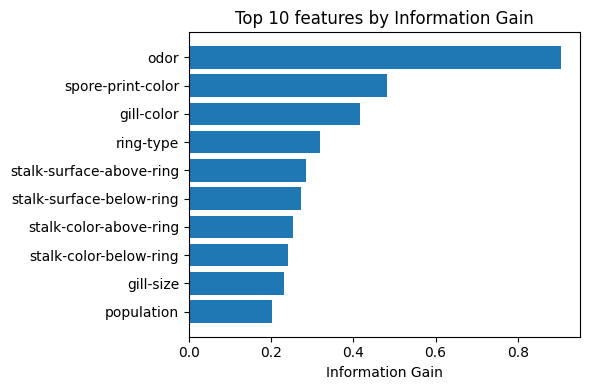

In [12]:
# Bar plot: Top 10 χαρακτηριστικά βάσει Information Gain
top_ig = scores.sort_values("info_gain", ascending=False).head(10)

plt.figure(figsize=(6, 4))
plt.barh(top_ig["feature"], top_ig["info_gain"])
plt.xlabel("Information Gain")
plt.title("Top 10 features by Information Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

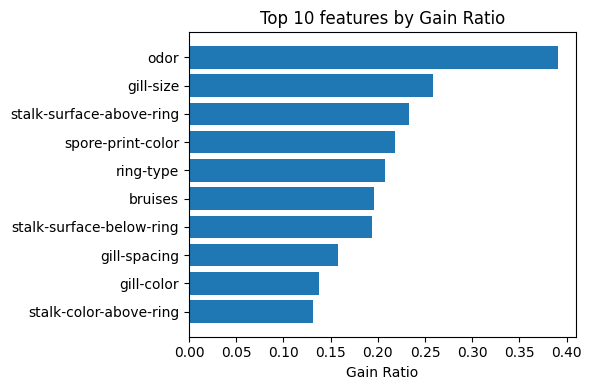

In [13]:
# Bar plot: Top 10 χαρακτηριστικά βάσει Gain Ratio
top_gr = scores.sort_values("gain_ratio", ascending=False).head(10)

plt.figure(figsize=(6, 4))
plt.barh(top_gr["feature"], top_gr["gain_ratio"])
plt.xlabel("Gain Ratio")
plt.title("Top 10 features by Gain Ratio")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

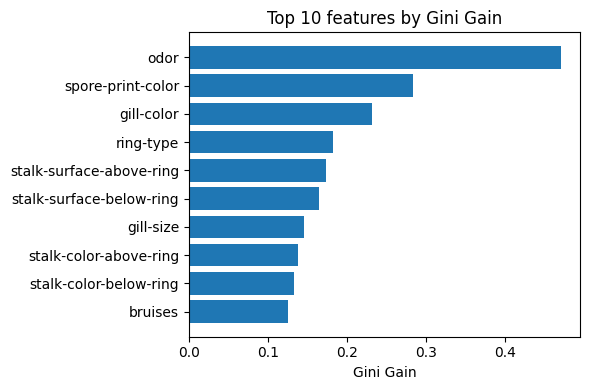

In [14]:
# Bar plot: Top 10 χαρακτηριστικά βάσει Gini Gain
top_gg = scores.sort_values("gini_gain", ascending=False).head(10)

plt.figure(figsize=(6, 4))
plt.barh(top_gg["feature"], top_gg["gini_gain"])
plt.xlabel("Gini Gain")
plt.title("Top 10 features by Gini Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()